# Sydney Crime Predictor
## This Notebook attempts to predict the type of crime that will occur based on the suburb and time 

In [139]:
#Import the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib.font_manager import FontProperties
import seaborn as sns
fontP = FontProperties()
fontP.set_size('small')
from sklearn.ensemble import RandomForestClassifier
np.random.seed(0)
%matplotlib inline


In [140]:
#load data
df=pd.read_csv(r'C:\Users\sidha\p-d4dsydney-hotspot\crime_data',parse_dates =True)

In [141]:
#print("No missing values and a clean dataset --- >\n",df.isnull().sum())
#spot check to spot any abnormal values
df.describe()

,FID,OBJECTID,locpcode,bcsrgclat,bcsrgclng,incyear,eventyr,poi_age,uniqueID
count,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,23605.000000,2.360500e+04
mean,11802.000000,12590.332514,2011.205719,-33.880301,151.210208,2014.131752,2014.135946,16.170950,5.804016e+07
std,6814.320888,9264.657055,10.317431,0.011017,0.011239,0.959974,0.958041,19.377810,1.073130e+07
min,0.000000,1.000000,2000.000000,-33.923440,151.174966,2008.000000,2013.000000,0.000000,4.764253e+07
25%,5901.000000,4161.000000,2006.000000,-33.887880,151.204530,2013.000000,2013.000000,0.000000,5.306269e+07
50%,11802.000000,10808.000000,2010.000000,-33.877780,151.210830,2014.000000,2014.000000,0.000000,5.606564e+07
75%,17703.000000,20554.000000,2015.000000,-33.872960,151.219245,2015.000000,2015.000000,32.232717,5.909751e+07
max,23604.000000,30488.000000,2050.000000,-33.852369,151.233010,2016.000000,2016.000000,88.039699,1.176991e+08


In [142]:
#Data type check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23605 entries, 0 to 23604
Data columns (total 20 columns):
FID          23605 non-null int64
OBJECTID     23605 non-null int64
bcsrgrp      23605 non-null object
bcsrcat      23605 non-null object
lganame      23605 non-null object
locsurb      23605 non-null object
locprmc1     23605 non-null object
locpcode     23605 non-null int64
bcsrgclat    23605 non-null float64
bcsrgclng    23605 non-null float64
bcsrgccde    23605 non-null object
incyear      23605 non-null int64
incmonth     23605 non-null object
incday       23605 non-null object
incsttm      23605 non-null object
eventyr      23605 non-null int64
eventmth     23605 non-null object
poisex       23605 non-null object
poi_age      23605 non-null float64
uniqueID     23605 non-null int64
dtypes: float64(3), int64(6), object(11)
memory usage: 3.6+ MB


In [143]:
#train test split
#we will take the incidents that occured in year 2016 as test data set
test=df[df.incyear==2016]
train=df[df.incyear!=2016]

In [144]:
# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train))
print('Number of observations in the test data:',len(test))

Number of observations in the training data: 21727
Number of observations in the test data: 1878


In [145]:
#Function to derive zone,the probability that an incident occurs late night or early morning is more so the time itself is not relevant
#its better to group then in zones from zone1 begining from 12 AM to zone6 that ends at 11:59PM

def inctime_to_zone(df):
    incsttm_zone=[]
    for i in df['incsttm']:
        if int(i.split(':')[0])in range(0,4):
            incsttm_zone.append('zone1')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(4,8):
            incsttm_zone.append('zone2')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(8,12):
            incsttm_zone.append('zone3')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(12,16):
            incsttm_zone.append('zone4')
            #print(i.split(':')[0])
        elif int(i.split(':')[0])in range(16,20):
            incsttm_zone.append('zone5')
            #print(i.split(':')[0])
        else:
            incsttm_zone.append('zone6')
            #print(i.split(':')[0])

    df['incsttm_zone']=incsttm_zone

In [146]:
#Apply function to both train test set
inctime_to_zone(train)
inctime_to_zone(test)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [147]:
#Function to replace entire month names with numeric
#String numbers has been intentionally chosen
def month_to_int(df):
    month_dict={'January':'01','February':'02','March':'03','April':'04','May':'05','June':'06','July':'07','August':'08','September':'09','October':'10','November':'11','December':'12'}
    df['incmthint']=df.incmonth.apply(lambda x:month_dict[x])

In [148]:
month_to_int(train)
month_to_int(test)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [149]:
def month_key(df1,colyr,colmth):
    df1['incmthkey']=df1[colyr].apply(str)+df1[colmth].apply(str)
    df1['incmthkey'].unique()

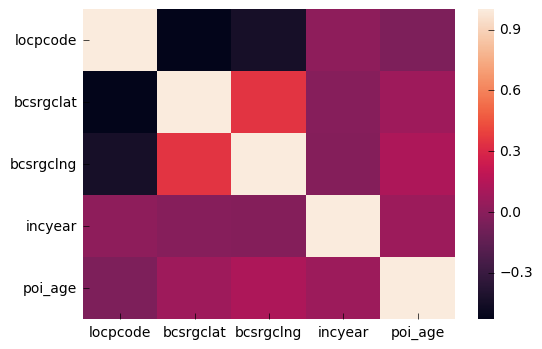

In [182]:
train_dropid=train.drop(['FID','uniqueID','OBJECTID','eventyr'],axis=1)
corr=train_dropid.corr()
sns.heatmap(corr)

In [167]:
train.poi_age.unique()

array([  0.        ,  50.33196441,  21.88295688, ...,  31.7412731 ,
        26.48186174,  15.66735113])

ValueError: object too deep for desired array

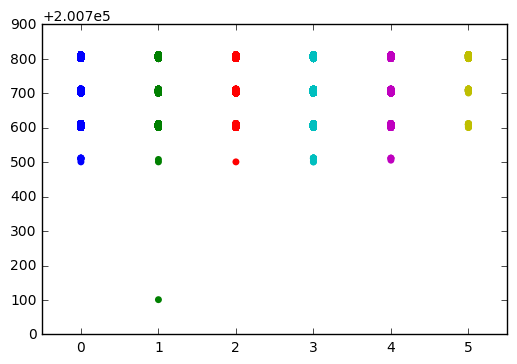

In [173]:
# sns.swarmplot(x='bcsrgccde', y='incmthkey', data=train)

In [150]:
# train.incyear.apply(str)+train.incmthint.apply(str)
month_key(train,'incyear','incmthint')
month_key(test,'incyear','incmthint')

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [183]:
#  sns.heatmap(df, vmin=0, vmax=1)

In [151]:
#EDA on crime categories based on the time attributes

incyear


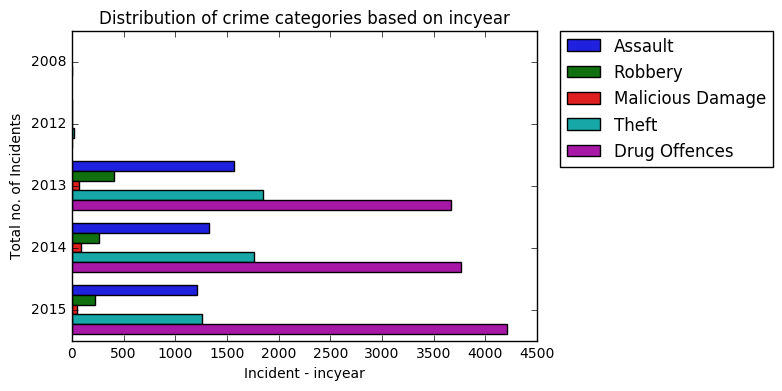

incmthint


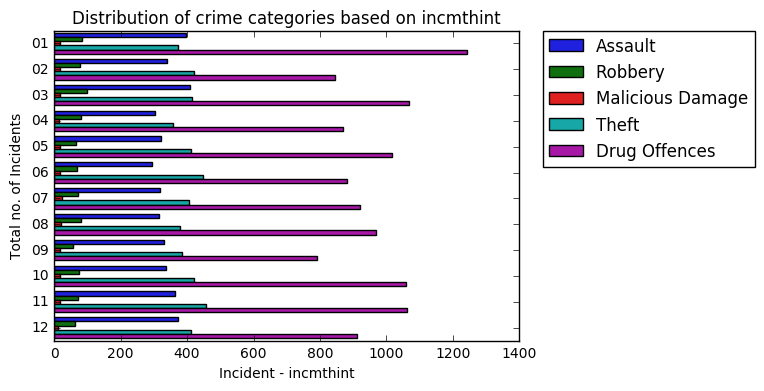

incday


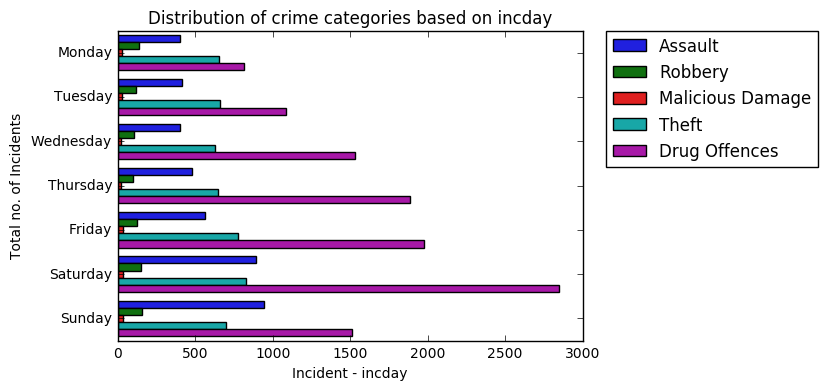

incsttm_zone


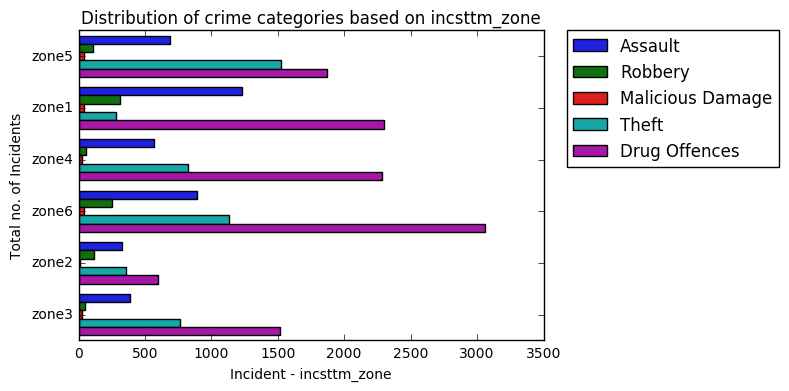

bcsrgccde


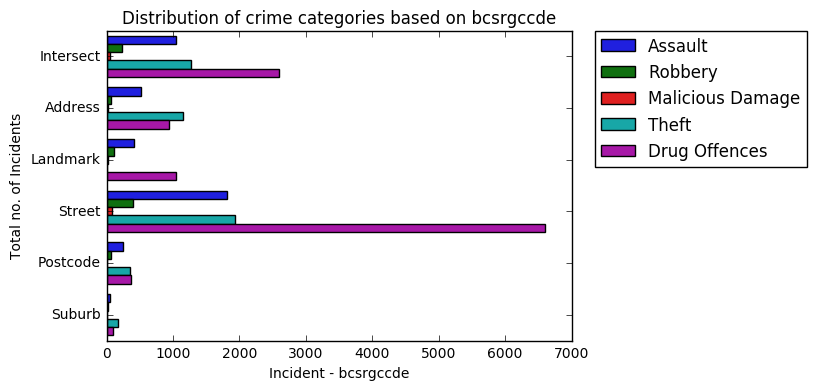

In [184]:
for i in list(['incyear','incmthint','incday','incsttm_zone','bcsrgccde']):
    print(i)
    sns.countplot(y=i, data=train,orient='h',hue='bcsrgrp')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title('Distribution of crime categories based on '+(i))
    plt.xlabel("Incident - "+i)
    plt.ylabel("Total no. of Incidents")
    plt.savefig(i+'.png', bbox_inches='tight')
    plt.show()

### Key Observations
1.Drug offecens have increased YoY  
2.Saturdays have a very high incident on drug abuse  
3.zone6 (12 to 4 AM) is when drug abuse peaks   
4.Theft is more common in late evenings   

In [154]:
train['poisex'].replace([' '],['U'],inplace=True)
test['poisex'].replace([' '],['U'],inplace=True)


C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


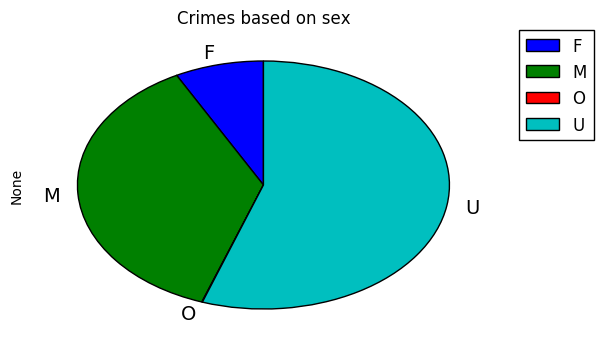

In [155]:

train.groupby(['poisex']).size().plot.pie(y='poisex',fontsize=14,startangle=90, shadow=False)
plt.title('Crimes based on sex')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.figure(figsize=(16,8))
plt.savefig('Crimes based on sex'+'.png', bbox_inches='tight')
plt.show()

Count plot based on Type of crime YoY

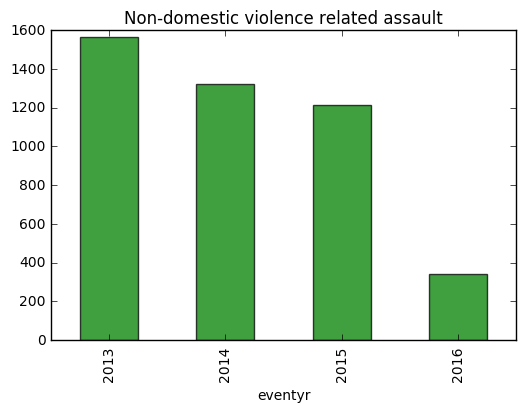

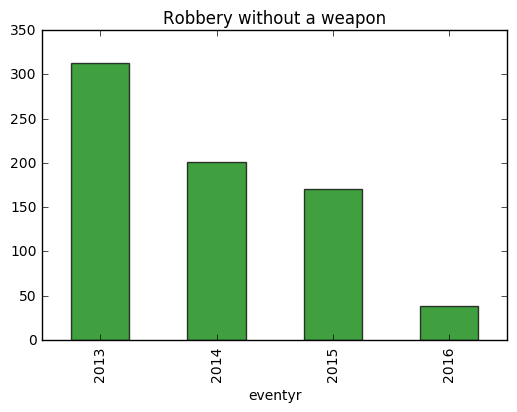

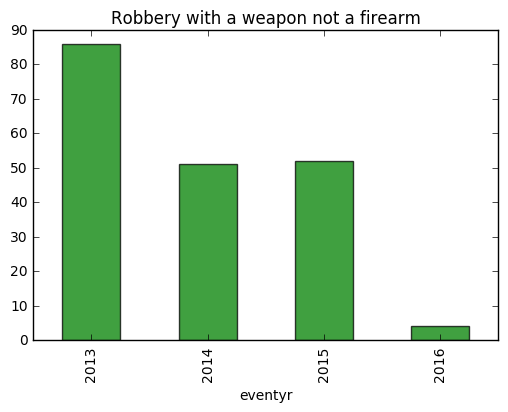

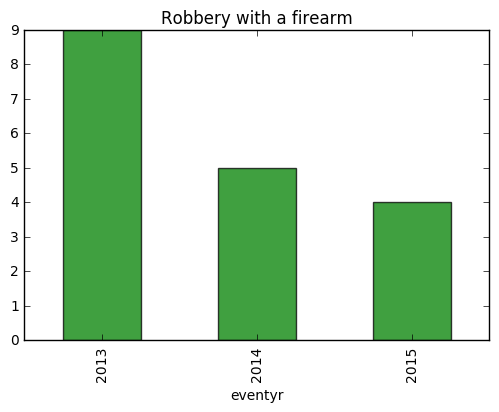

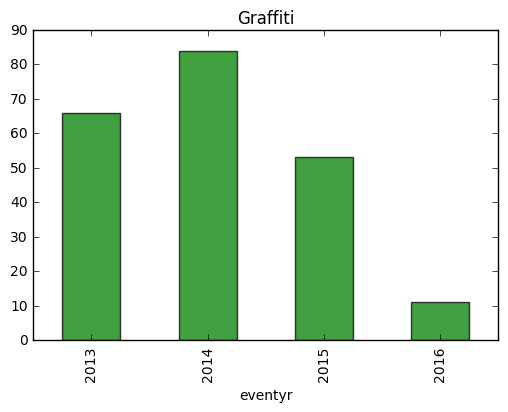

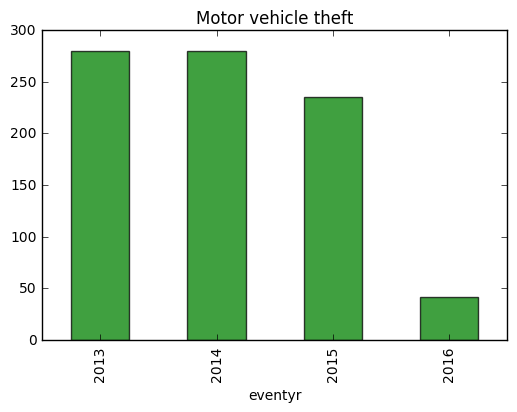

FileNotFoundError: [Errno 2] No such file or directory: 'Possession and/or use of amphetamines.png'

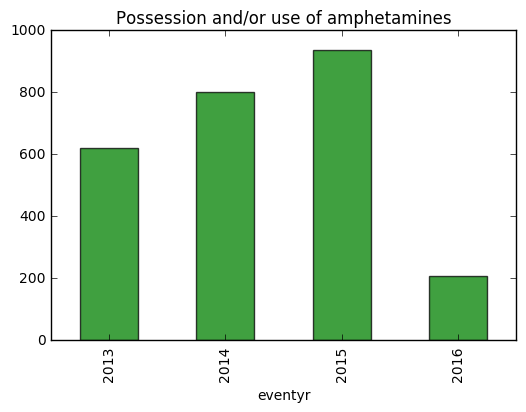

In [156]:
for i in df.bcsrcat.unique():
    df[df['bcsrcat']==i].groupby(['eventyr']).size().plot(kind='bar',alpha=0.75,color='g')
    plt.title(i)
    plt.savefig(i+'.png', bbox_inches='tight')

    plt.show()
#     df[df['bcsrcat']==i].groupby(['eventyr']).size().unstack().plot(kind='line',alpha=0.75)
#     plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))
#     fig = plt.figure()
#     plt.show()

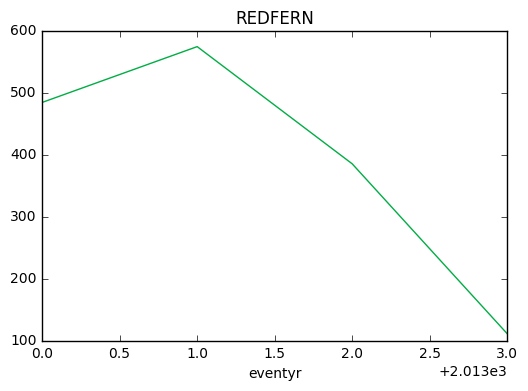

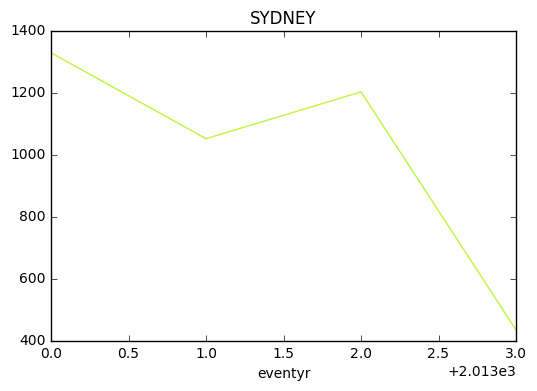

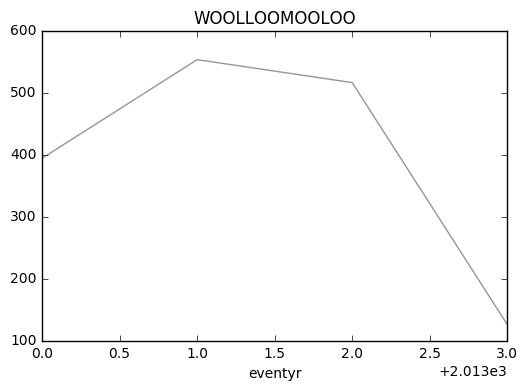

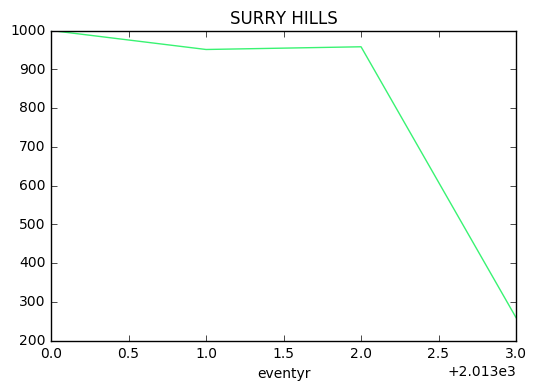

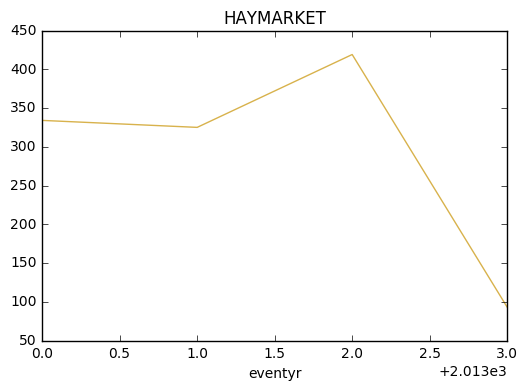

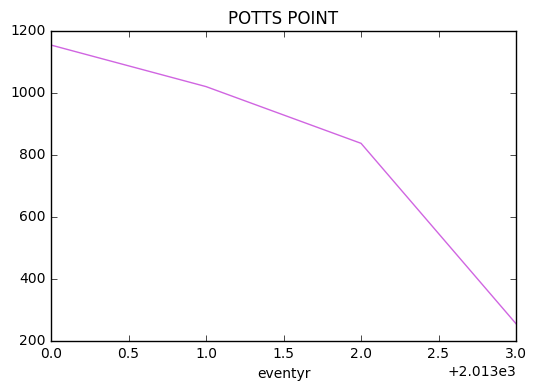

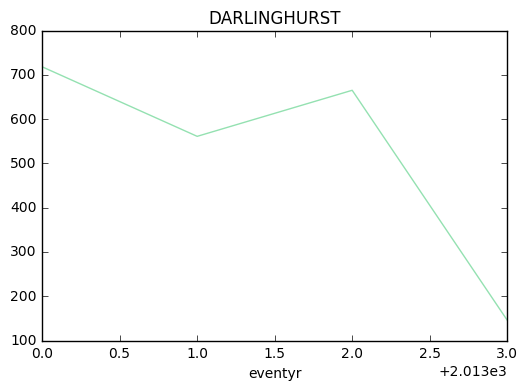

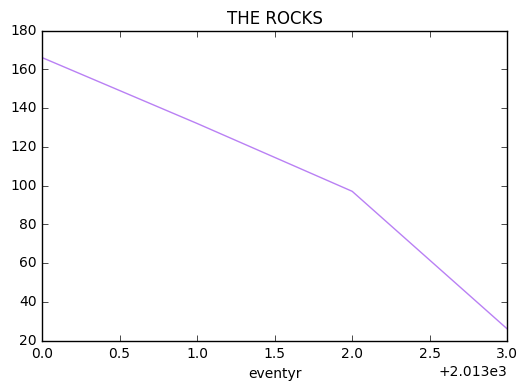

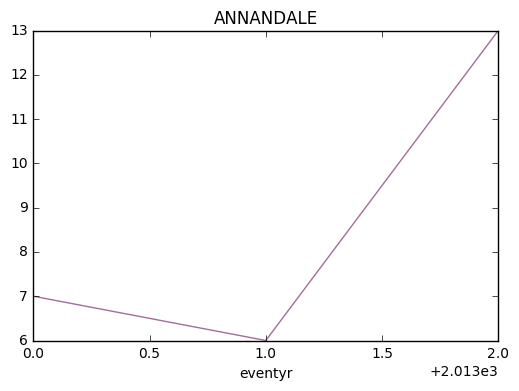

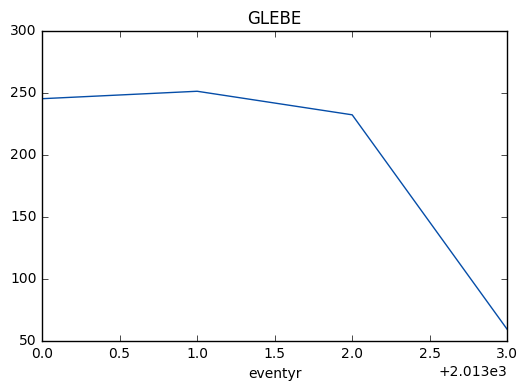

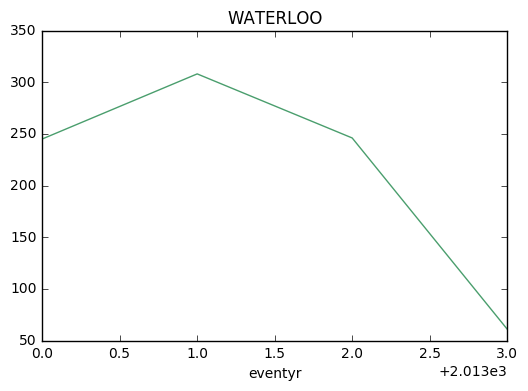

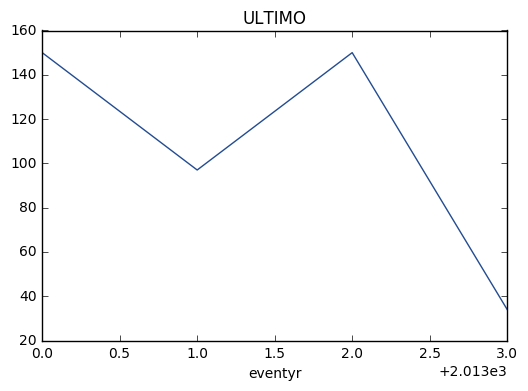

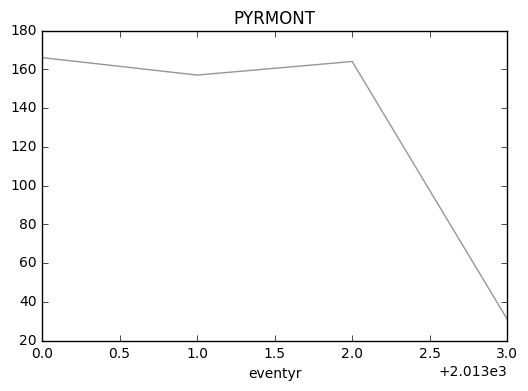

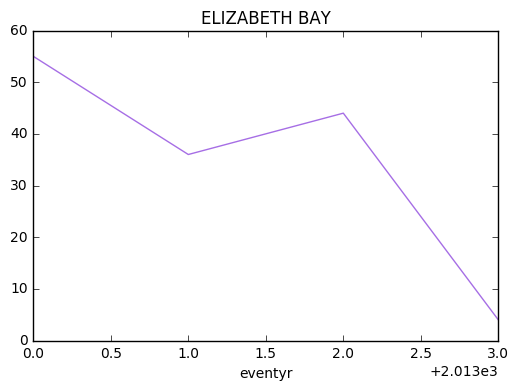

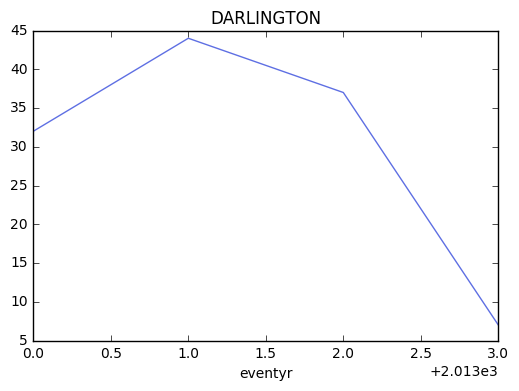

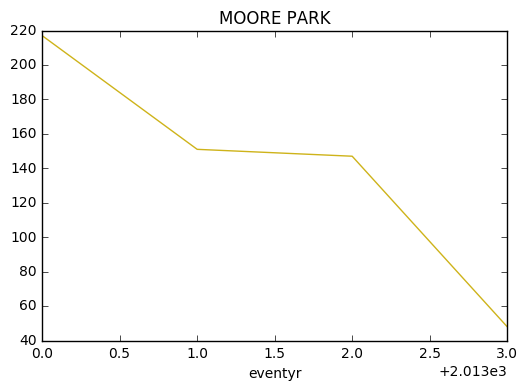

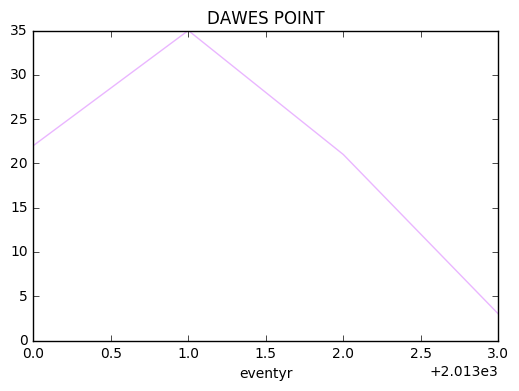

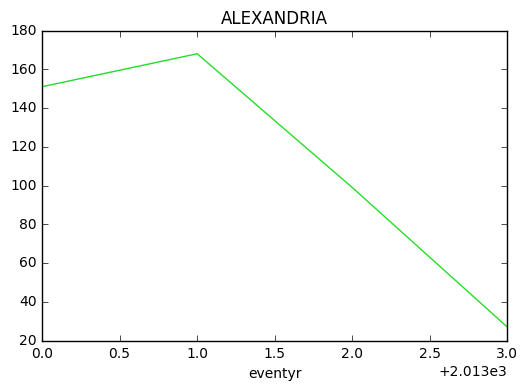

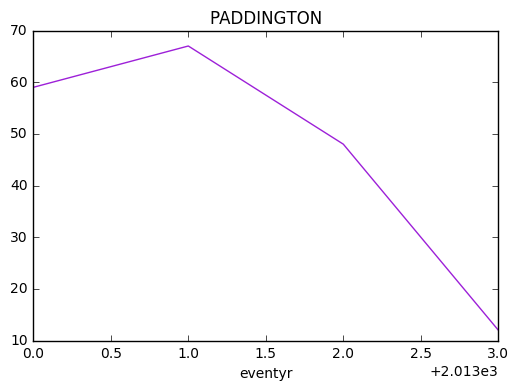

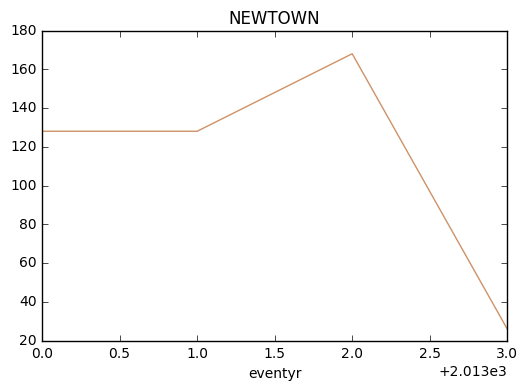

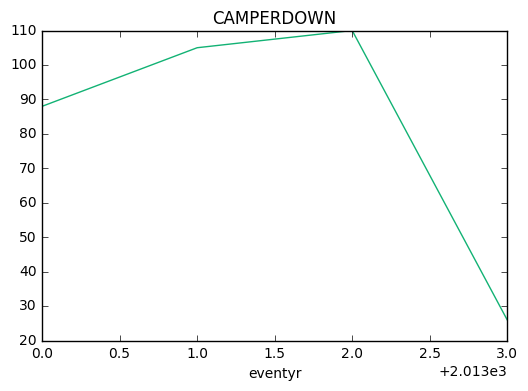

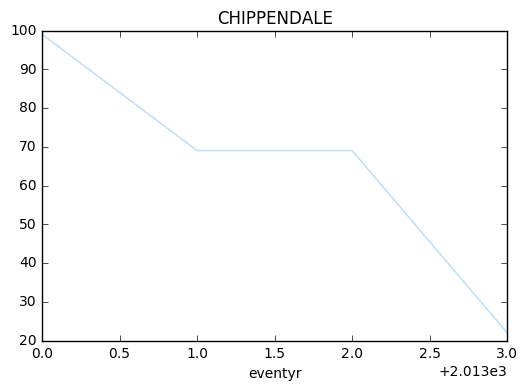

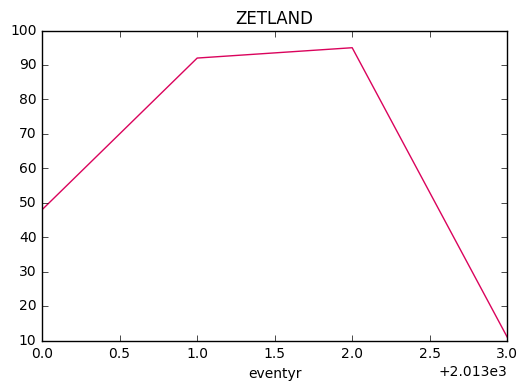

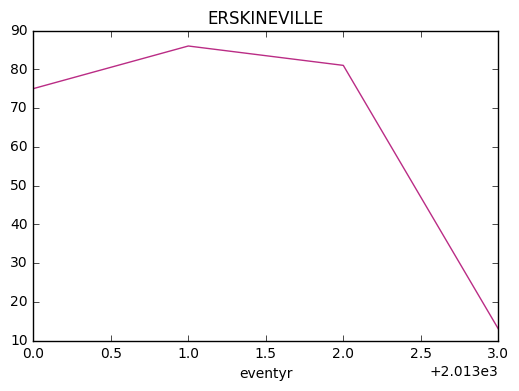

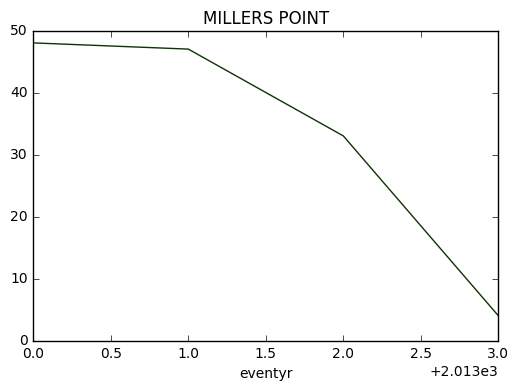

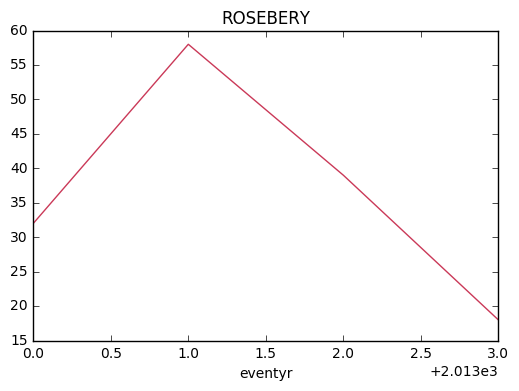

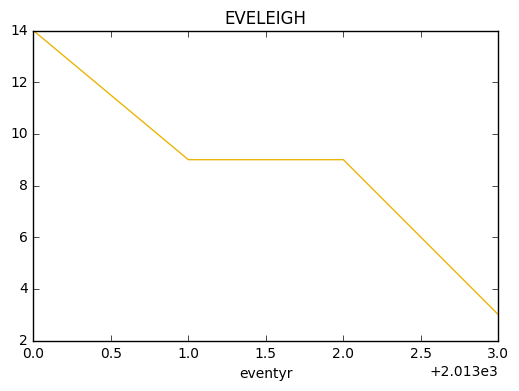

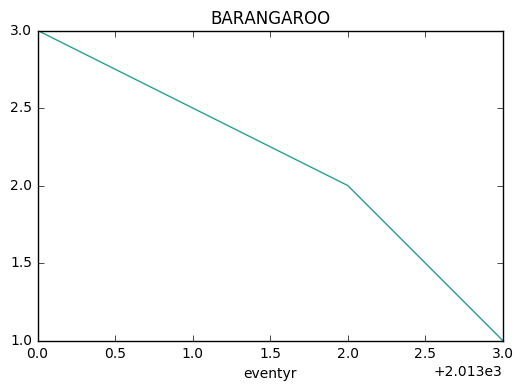

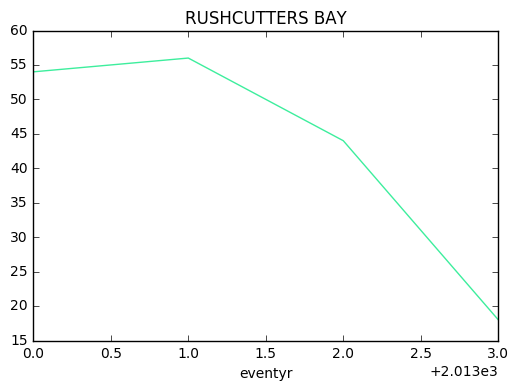

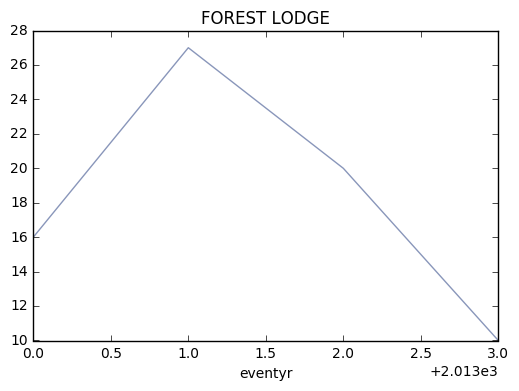

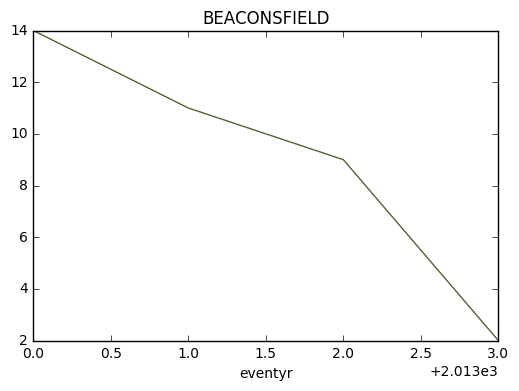

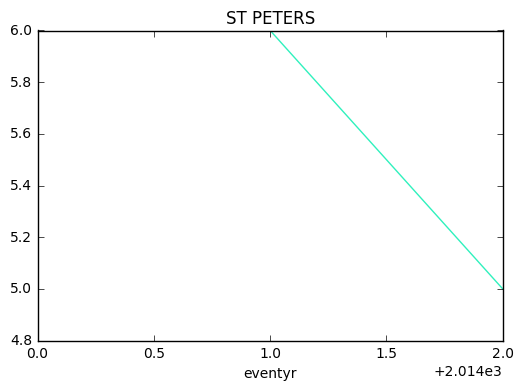

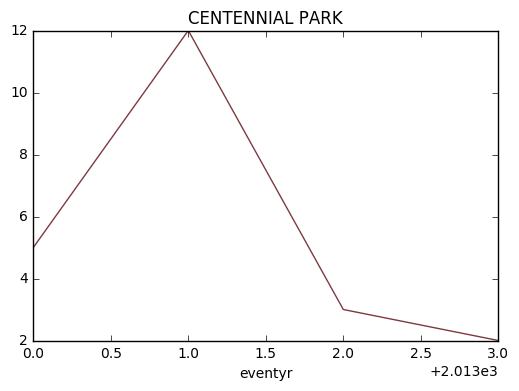

In [117]:
for i in df.locsurb.unique():
    df[(df['locsurb']==i) & (df['locsurb']!='Sydney')].groupby(['eventyr']).size().head(5).plot(kind='line',alpha=1,color=np.random.rand(3,1))
    plt.title(i)
    plt.show()

In [115]:
df1=df[df.locsurb!='SYDNEY'][['locsurb','eventyr']].groupby(['locsurb','eventyr'],as_index=False).size().unstack()
# df1.reset_index()
# df1.sort_values(by=['2013'])
df1.columns
# .head(5).plot(kind='barh',alpha=1)

Int64Index([2013, 2014, 2015, 2016], dtype='int64', name='eventyr')

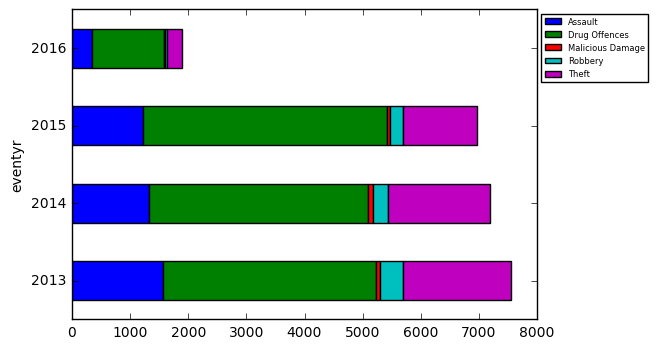

In [113]:
table=pd.pivot_table(df,values='FID',index=['eventyr'],aggfunc=np.size,columns='bcsrgrp')
table.plot(kind='barh',stacked='True')
plt.legend(loc='upper left', prop={'size':6}, bbox_to_anchor=(1,1))
plt.figure(figsize=(80, 40), dpi= 80, facecolor='w', edgecolor='k')
plt.show()

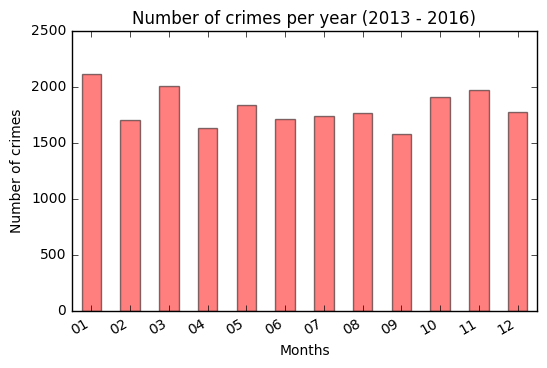

In [121]:
df_4=train.groupby(['incmthint']).size()

df_4.plot(kind='bar',legend=False,color='r',alpha=0.5)
plt.title('Number of crimes per year (2013 - 2016)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.gcf().autofmt_xdate()
plt.show()

In [122]:
#Model Building Begin with random forest
train.columns


Index(['FID', 'OBJECTID', 'bcsrgrp', 'bcsrcat', 'lganame', 'locsurb',
       'locprmc1', 'locpcode', 'bcsrgclat', 'bcsrgclng', 'bcsrgccde',
       'incyear', 'incmonth', 'incday', 'incsttm', 'eventyr', 'eventmth',
       'poisex', 'poi_age', 'uniqueID', 'incsttm_zone', 'incmthint',
       'incmthkey'],
      dtype='object')

In [123]:
train_copy=train

In [124]:
train['bcsrgrp'].replace(['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],[1,2,3,4,5],inplace=True)
test['bcsrgrp'].replace(['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],[1,2,3,4,5],inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [125]:
y_train=train['bcsrgrp']
y_test=test['bcsrgrp']

In [126]:
print('train bcsrgrp unique value are now:', train['bcsrgrp'].unique())
print('test bcsrgrp unique value are now:', test['bcsrgrp'].unique())

train bcsrgrp unique value are now: [1 2 3 4 5]
test bcsrgrp unique value are now: [1 2 3 4 5]


In [127]:
train.drop(['FID', 'OBJECTID','lganame','locprmc1','locpcode','bcsrgclat','bcsrgclng','uniqueID'],axis=1,inplace=True)
test.drop(['FID', 'OBJECTID','lganame','locprmc1','locpcode','bcsrgclat','bcsrgclng','uniqueID'],axis=1,inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [128]:
train.drop(['bcsrgrp'],axis=1,inplace=True)
test.drop(['bcsrgrp'],axis=1,inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [129]:
low_cardinality_cols = [cname for cname in train.columns if 
                                train[cname].nunique() < 40 and
                                train[cname].dtype == "object"]
numeric_cols = [cname for cname in train.columns if 
                                train[cname].dtype in ['int64', 'float64']]
my_cols = low_cardinality_cols + numeric_cols
train_predictors = train[my_cols]
test_predictors = test[my_cols]

In [130]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21727 entries, 0 to 23400
Data columns (total 14 columns):
bcsrcat         21727 non-null object
locsurb         21727 non-null object
bcsrgccde       21727 non-null object
incyear         21727 non-null int64
incmonth        21727 non-null object
incday          21727 non-null object
incsttm         21727 non-null object
eventyr         21727 non-null int64
eventmth        21727 non-null object
poisex          21727 non-null object
poi_age         21727 non-null float64
incsttm_zone    21727 non-null object
incmthint       21727 non-null object
incmthkey       21727 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 2.5+ MB


In [131]:
test.isnull().sum()

bcsrcat         0
locsurb         0
bcsrgccde       0
incyear         0
incmonth        0
incday          0
incsttm         0
eventyr         0
eventmth        0
poisex          0
poi_age         0
incsttm_zone    0
incmthint       0
incmthkey       0
dtype: int64

In [132]:
# len(train.columns)
train.columns

Index(['bcsrcat', 'locsurb', 'bcsrgccde', 'incyear', 'incmonth', 'incday',
       'incsttm', 'eventyr', 'eventmth', 'poisex', 'poi_age', 'incsttm_zone',
       'incmthint', 'incmthkey'],
      dtype='object')

In [133]:
# len(train_predictors.columns)
train_predictors.columns

Index(['bcsrcat', 'locsurb', 'bcsrgccde', 'incmonth', 'incday', 'eventmth',
       'poisex', 'incsttm_zone', 'incmthint', 'incyear', 'eventyr', 'poi_age'],
      dtype='object')

In [134]:
print("shape of training set",train_predictors.shape)
print("shape of test set",test_predictors.shape)

shape of training set (21727, 12)
shape of test set (1878, 12)


In [171]:
one_hot_encoded_training_predictors = pd.get_dummies(train_predictors)

one_hot_encoded_testing_predictors = pd.get_dummies(test_predictors)


In [172]:
final_train, final_test = one_hot_encoded_training_predictors.align(one_hot_encoded_testing_predictors,
                                                                    join='left', 
                                                                    axis=1)


In [151]:
print(final_train.shape)
print(final_test.shape)

(21727, 83)
(1878, 83)


In [186]:
imp=Imputer(strategy='most_frequent')
final_train=imp.fit_transform(final_train)
final_test=imp.transform(final_test)


In [187]:
clf = RandomForestClassifier(n_jobs=2, random_state=0,n_estimators=500)
clf.fit(final_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [188]:
pred_vals=clf.predict(final_test)

In [189]:
pred_vals

array([4, 5, 1, ..., 5, 4, 4], dtype=int64)

In [192]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, pred_vals)

0.6906283280085197

In [194]:
y_test_list=list(y_test)
pred_vals_list=list(pred_vals)

In [2]:
#Check
print ("Number of rows in test output ",len(y_test_list))
print("Number of rows in predicted output ",len(pred_vals_list))

NameError: name 'y_test_list' is not defined

In [201]:
test['y_test_list']=y_test_list
test['pred_vals_list']=pred_vals_list

C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\sidha\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [202]:
test.shape

(1878, 11)

In [204]:
test['y_test_list'].replace([1,2,3,4,5],['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],inplace=True)
test['pred_vals_list'].replace([1,2,3,4,5],['Assault', 'Robbery', 'Malicious Damage', 'Theft', 'Drug Offences'],inplace=True)

C:\Users\sidha\Anaconda3\lib\site-packages\pandas\core\generic.py:3443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Correctly Predicted Crimes

In [209]:

test[test['y_test_list']==test['pred_vals_list']].groupby('y_test_list').size()

y_test_list
Assault            88
Drug Offences    1046
Robbery             1
Theft             162
dtype: int64

### Incorrectly Predicted Crimes

In [210]:

test[test['y_test_list']!=test['pred_vals_list']].groupby('y_test_list').size()

y_test_list
Assault             251
Drug Offences       197
Malicious Damage     11
Robbery              41
Theft                81
dtype: int64

In [213]:
print("Total Predictions : ",len(test))
print("Correct Predictions : ",len(test[test['y_test_list']==test['pred_vals_list']]))
print("Incorrect Predictions : ",len(test[test['y_test_list']!=test['pred_vals_list']]))

Total Predictions :  1878
Correct Predictions :  1297
Incorrect Predictions :  581


Predicting whether 

In [135]:
print("The shape of train is ",train_predictors.shape)
print("The shape of test is ",test_predictors.shape)

The shape of train is  (21727, 12)
The shape of test is  (1878, 12)


,bcsrcat,locsurb,bcsrgccde,incmonth,incday,eventmth,poisex,incsttm_zone,incmthint,incyear,eventyr,poi_age
0,Non-domestic violence related assault,REDFERN,Intersect,August,Monday,February,U,zone5,08,2012,2013,0.000000
1,Non-domestic violence related assault,SYDNEY,Intersect,October,Tuesday,February,U,zone5,10,2012,2013,0.000000
2,Non-domestic violence related assault,WOOLLOOMOOLOO,Address,January,Tuesday,January,U,zone1,01,2013,2013,0.000000
3,Non-domestic violence related assault,WOOLLOOMOOLOO,Intersect,January,Tuesday,January,U,zone1,01,2013,2013,0.000000
4,Non-domestic violence related assault,SURRY HILLS,Intersect,January,Tuesday,January,M,zone4,01,2013,2013,50.331964


In [185]:
train

,FID,OBJECTID,bcsrgrp,bcsrcat,lganame,locsurb,locprmc1,locpcode,bcsrgclat,bcsrgclng,...,incday,incsttm,eventyr,eventmth,poisex,poi_age,uniqueID,incsttm_zone,incmthint,incmthkey
0,0,1,Assault,Non-domestic violence related assault,Sydney,REDFERN,OUTDOOR/PUBLIC PLACE,2016,-33.892390,151.214790,...,Monday,16:00,2013,February,U,0.000000,50658277,zone5,08,201208
1,1,2,Assault,Non-domestic violence related assault,Sydney,SYDNEY,OUTDOOR/PUBLIC PLACE,2000,-33.867700,151.209840,...,Tuesday,18:00,2013,February,U,0.000000,53061821,zone5,10,201210
2,2,3,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.872671,151.219100,...,Tuesday,1:30,2013,January,U,0.000000,50001248,zone1,01,201301
3,3,5,Assault,Non-domestic violence related assault,Sydney,WOOLLOOMOOLOO,OUTDOOR/PUBLIC PLACE,2011,-33.870260,151.220190,...,Tuesday,3:00,2013,January,U,0.000000,49962948,zone1,01,201301
4,4,6,Assault,Non-domestic violence related assault,Sydney,SURRY HILLS,OUTDOOR/PUBLIC PLACE,2010,-33.880070,151.215001,...,Tuesday,12:51,2013,January,M,50.331964,49970181,zone4,01,201301
5,5,9,Assault,Non-domestic violence related assault,Sydney,HAYMARKET,OUTDOOR/PUBLIC PLACE,2000,-33.882432,151.206701,...,Tuesday,2:00,2013,January,U,0.000000,49591182,zone1,01,201301
6,6,11,Assault,Non-domestic violence related assault,Sydney,POTTS POINT,OUTDOOR/PUBLIC PLACE,2011,-33.875190,151.224510,...,Tuesday,2:50,2013,January,M,21.882957,49808414,zone1,01,201301
7,7,12,Assault,Non-domestic violence related assault,Sydney,SYDNEY,OUTDOOR/PUBLIC PLACE,2000,-33.863096,151.213056,...,Tuesday,2:40,2013,January,M,24.149897,49957271,zone1,01,201301
8,8,13,Assault,Non-domestic violence related assault,Sydney,DARLINGHURST,OUTDOOR/PUBLIC PLACE,2010,-33.874540,151.212542,...,Tuesday,0:30,2013,January,U,0.000000,49472659,zone1,01,201301
9,9,14,Assault,Non-domestic violence related assault,Sydney,THE ROCKS,OUTDOOR/PUBLIC PLACE,2000,-33.856479,151.207925,...,Tuesday,0:01,2013,January,U,0.000000,49898669,zone1,01,201301
